In [1]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import re

class Word2Vec:
    def __init__(self, window_size, embedding_size, learning_rate, epochs, negative_samples, random_state=None):
        self.window_size = window_size
        self.embedding_size = embedding_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.negative_samples = negative_samples
        self.word2id = {}
        self.id2word = {}
        self.vocab_size = 0
        self.random_state = random_state

    def count_words(self, tokens):
        # Count the occurrences of each word in the tokens
        word_counts = Counter()
        for sentence in tokens:
            word_counts.update(sentence)
        return word_counts

    def create_vocabularies(self, word_counts):
        # Create word-to-index and index-to-word mappings for the vocabulary
        vocab = {word: i for i, word in enumerate(word_counts)}
        inv_vocab = {i: word for word, i in vocab.items()}
        return vocab, inv_vocab

    def generate_training_data(self, tokens, vocab):
        # Generate training data by creating (center_word, context_word) pairs
        training_data = []
        for sentence in tokens:
            for center_word_pos in range(len(sentence)):
                center_word = sentence[center_word_pos]
                context_words = sentence[max(0, center_word_pos - self.window_size):center_word_pos] + \
                                sentence[center_word_pos + 1:center_word_pos + self.window_size + 1]
                for context_word in context_words:
                    training_data.append((center_word, context_word))
        return training_data

    def initialize_word_vectors(self, vocab_size):
        # Initialize word vectors with random values between -1 and 1
        self.vocab_size = vocab_size
        self.word_vectors = np.random.uniform(-1, 1, (vocab_size, self.embedding_size))

    def train(self, training_data):
        # Train the Word2Vec model using the training data
        for epoch in range(self.epochs):
            total_loss = 0
            np.random.shuffle(training_data)

            for center_word, context_word in training_data:
                center_word_idx = self.word2id[center_word]
                context_word_idx = self.word2id[context_word]

                # Positive example
                center_vec = self.word_vectors[center_word_idx]
                context_vec = self.word_vectors[context_word_idx]

                # Calculate dot product
                dot_product = np.sum(center_vec * context_vec)
                # Sigmoid activation
                sigmoid = 1 / (1 + np.exp(-dot_product))
                # Calculate loss
                loss = -np.log(sigmoid)
                total_loss += loss

                # Gradient calculation
                grad = (sigmoid - 1) * self.learning_rate

                # Update word vectors
                self.word_vectors[center_word_idx] -= grad * context_vec
                self.word_vectors[context_word_idx] -= grad * center_vec


                # Negative sampling
                negative_samples_idx = np.random.choice(self.vocab_size, self.negative_samples, replace=False)
                neg_word_vecs = self.word_vectors[negative_samples_idx]
                neg_dot_products = np.sum(center_vec * neg_word_vecs, axis=1)
                neg_sigmoids = 1 / (1 + np.exp(-neg_dot_products))
                neg_grads = neg_sigmoids * self.learning_rate
                self.word_vectors[center_word_idx] -= np.dot(neg_grads, neg_word_vecs)


            avg_loss = total_loss / len(training_data)
            print(f"Epoch: {epoch + 1} Loss: {avg_loss}")

    def fit(self, corpus):
        # Preprocess the corpus and train the Word2Vec model
        tokens = re.split(r'\.|\?|!', corpus)  # Split the corpus into sentences using appropriate punctuation marks
        tokens = [re.sub(r"[,.:]", "", sentence.lower()).split() for sentence in tokens]  # Preprocess each sentence
        word_counts = self.count_words(tokens)
        self.word2id, self.id2word = self.create_vocabularies(word_counts)
        training_data = self.generate_training_data(tokens, self.word2id)
        vocab_size = len(self.word2id)
        self.initialize_word_vectors(vocab_size)
        self.train(training_data)

    def get_word_vector(self, word):
        # Get the word vector for a given word
        if word in self.word2id:
            word_id = self.word2id[word]
            return self.word_vectors[word_id]
        else:
            return None

    def create_word_vector_dataframe(self):
        # Create a DataFrame with word vectors
        df = pd.DataFrame(self.word_vectors, index=[self.id2word[i] for i in range(self.vocab_size)])
        return df

    def visualize_embeddings_pca(self):
        # Visualize word embeddings using PCA
        pca = PCA(n_components=2)
        embeddings_pca = pca.fit_transform(self.word_vectors)

        plt.figure(figsize=(10, 10))
        for i, word in self.id2word.items():
            x, y = embeddings_pca[i]
            plt.scatter(x, y)
            plt.annotate(word, (x, y), alpha=0.7)

        plt.show()

    def visualize_embeddings_tsne(self):
        # Visualize word embeddings using t-SNE
        tsne = TSNE(n_components=2)
        embeddings_tsne = tsne.fit_transform(self.word_vectors)

        plt.figure(figsize=(10, 10))
        for i, word in self.id2word.items():
            x, y = embeddings_tsne[i]
            plt.scatter(x, y)
            plt.annotate(word, (x, y), alpha=0.7)

        plt.show()

In [2]:
file_path = 'book.txt'

with open(file_path, 'r', encoding='utf-8') as file:
    corpus = file.read()

print(corpus)


Chapter 1
Title: The Great Adventure

Once upon a time, in a land far away, there lived a young hero named John. He was known for his bravery and determination. One day, a mysterious old man appeared before him and handed him a map.

"Follow this map, young hero," said the old man. "It will lead you to a great adventure."

Intrigued by the old man's words, John set off on his journey. The map guided him through dense forests, treacherous mountains, and vast deserts. Along the way, he encountered dangerous creatures and solved challenging puzzles.

After weeks of travel, John reached the final destination marked on the map. There, he discovered a hidden treasure that held immense power. With the treasure in his possession, John realized that he had the ability to change the world for the better.

Filled with a renewed sense of purpose, John returned to his village as a true hero. He used the power of the treasure to bring prosperity and happiness to his people. His name became legendary

In [3]:
np.random.seed(0)

window_size = 2
embedding_size = 50
learning_rate = 0.01
epochs = 150
negative_samples = 5
random_state = 1234

model = Word2Vec(window_size, embedding_size, learning_rate, epochs, negative_samples, random_state)
model.fit(corpus)

Epoch: 1 Loss: 1.1333907438278243
Epoch: 2 Loss: 0.8555930375705263
Epoch: 3 Loss: 0.6957659812670153
Epoch: 4 Loss: 0.5869927604336395
Epoch: 5 Loss: 0.515283482166747
Epoch: 6 Loss: 0.4652694349606032
Epoch: 7 Loss: 0.42874970545311625
Epoch: 8 Loss: 0.3995059148517569
Epoch: 9 Loss: 0.374474476237243
Epoch: 10 Loss: 0.3619042455387381
Epoch: 11 Loss: 0.3498584669572805
Epoch: 12 Loss: 0.34098862080594217
Epoch: 13 Loss: 0.3331932455276764
Epoch: 14 Loss: 0.3249837232120723
Epoch: 15 Loss: 0.3205835413310667
Epoch: 16 Loss: 0.31331836128041096
Epoch: 17 Loss: 0.30793702781773513
Epoch: 18 Loss: 0.30655113391539557
Epoch: 19 Loss: 0.30385106150207875
Epoch: 20 Loss: 0.30312986494220984
Epoch: 21 Loss: 0.3009654218398256
Epoch: 22 Loss: 0.3020238776326865
Epoch: 23 Loss: 0.3000807456061837
Epoch: 24 Loss: 0.29873247526788854
Epoch: 25 Loss: 0.29895621619077856
Epoch: 26 Loss: 0.2974387560409198
Epoch: 27 Loss: 0.2950761800768439
Epoch: 28 Loss: 0.2932102058925025
Epoch: 29 Loss: 0.2928

In [ ]:
# Show some word vector
# word_vector = model.get_word_vector('john')
# print(word_vector)

In [4]:
#Show some word vector
import random

# Randomly select a word from the corpus
random_word = random.choice(list(model.word2id.keys()))

# Get the word vector for the randomly selected word
word_vector = model.get_word_vector(random_word)

# Print the random word and its word vector
print("Random Word:", random_word)
print("Word Vector:", word_vector)

Random Word: purpose
Word Vector: [ 0.15417474  0.28612947 -0.45866375  0.27512393  0.0361504  -0.27013756
  0.40892627 -0.5173444  -0.07602655  0.49954451  0.31994728  0.06672884
 -0.22895106  0.23813462 -0.4272175  -0.47541346 -0.44126626  0.47890319
 -0.59932861  0.06532435 -0.308028    0.09290962 -0.02467089  0.20321333
 -0.33895038  0.20746426  0.30770685 -0.3249955   0.37205497 -0.06102197
 -0.1485885  -0.06451505  0.29205989  0.06564179  0.19095582  0.03430993
 -0.05563825  0.19396968 -0.78886209  0.22492591  0.13440508  0.06859635
  0.32762622  0.3176083  -0.40631181 -0.29949051 -0.44409187 -0.16813065
  0.49556851  0.35275726]


In [5]:
# Create DataFrame for all word vectors
df_word_vectors = model.create_word_vector_dataframe()

# Display the DataFrame as a table
display(df_word_vectors)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
chapter,0.285799,0.027300,0.145145,0.182573,-0.245781,0.052605,0.068902,0.388201,0.263540,-0.135322,...,0.016534,-0.008829,0.107455,-0.308120,0.461393,0.085919,-0.194034,-0.371070,-0.106718,0.062900
1,0.385889,-0.193212,0.595880,-0.153380,-0.659510,-0.415292,0.519178,-0.029259,0.122773,-0.544846,...,-0.087724,0.025034,-0.378277,0.307605,0.048166,-0.589033,-0.203899,-0.612904,0.471363,-0.649747
title,0.189083,-0.212575,0.184102,0.266231,-0.398313,0.020784,0.348788,0.321307,0.082215,-0.219482,...,0.277464,-0.082502,0.033738,-0.513928,0.443778,-0.372672,-0.197176,-0.156843,0.064670,0.206193
the,0.192791,-0.119844,-0.181168,0.077521,-0.035964,0.002063,0.366973,0.285242,0.094989,-0.583526,...,-0.133673,-0.169956,-0.121623,-0.273450,-0.195951,-0.475896,0.281354,-0.029771,0.079638,-0.053541
great,-0.008630,0.165982,-0.151623,-0.112513,-0.234446,-0.317739,0.309248,-0.011227,0.295660,-0.065916,...,-0.009424,-0.361455,0.125914,-0.550704,0.346297,-0.449550,0.139007,-0.013245,-0.040969,0.566283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
so,0.155472,0.227922,-0.209798,-0.626525,0.251474,0.222500,-0.686125,0.487484,-0.349468,-0.289841,...,-0.362580,0.384823,0.389971,0.626619,0.408982,-0.273819,0.363924,-0.525152,0.467884,0.077214
continued,0.050363,-0.114501,0.013940,-0.632175,-0.456502,0.319570,-0.535403,0.409561,-0.027756,0.127705,...,-0.310736,-0.090764,0.226217,0.085951,-0.390353,0.032608,0.331535,-0.213967,0.466446,0.484586
protector,-0.569721,-0.102039,0.207991,0.467710,0.355107,0.413881,0.276941,-0.305373,-0.301407,-0.074175,...,0.291213,-0.142274,0.391772,-0.119165,-0.547028,-0.178543,0.485713,0.207677,0.320427,-0.222743
ensuring,0.191538,-0.432491,0.585689,-0.524807,0.340219,0.520591,0.093860,0.321221,0.391852,-0.208059,...,0.274806,0.320834,0.115731,-0.374178,-0.667875,-0.608647,-0.096920,-0.166738,-0.680411,-0.193706


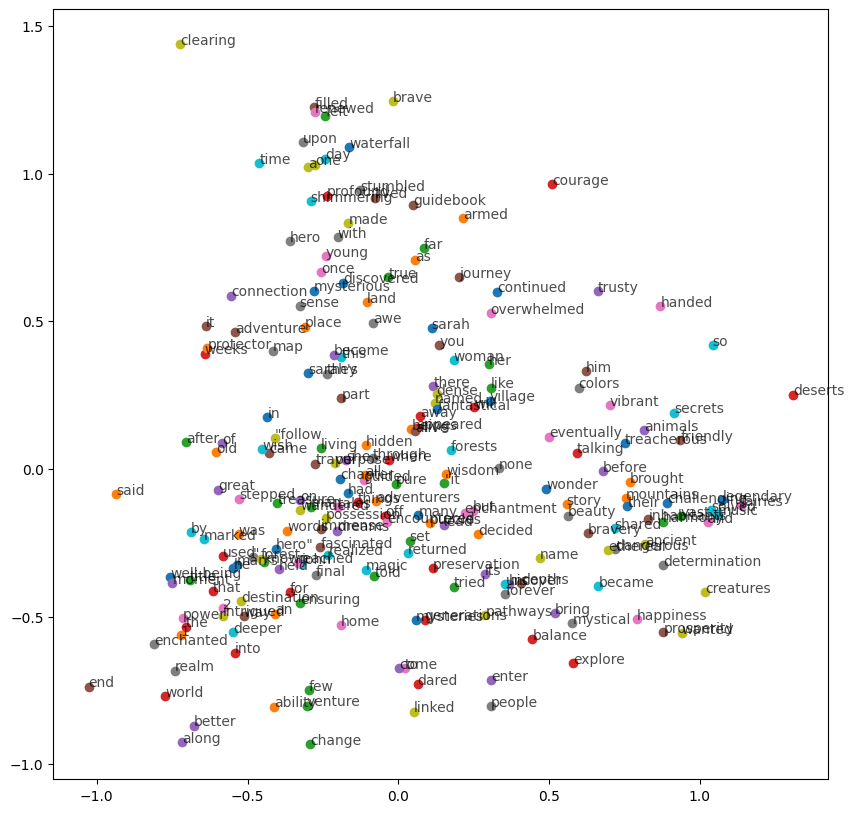

In [6]:
model.visualize_embeddings_pca()

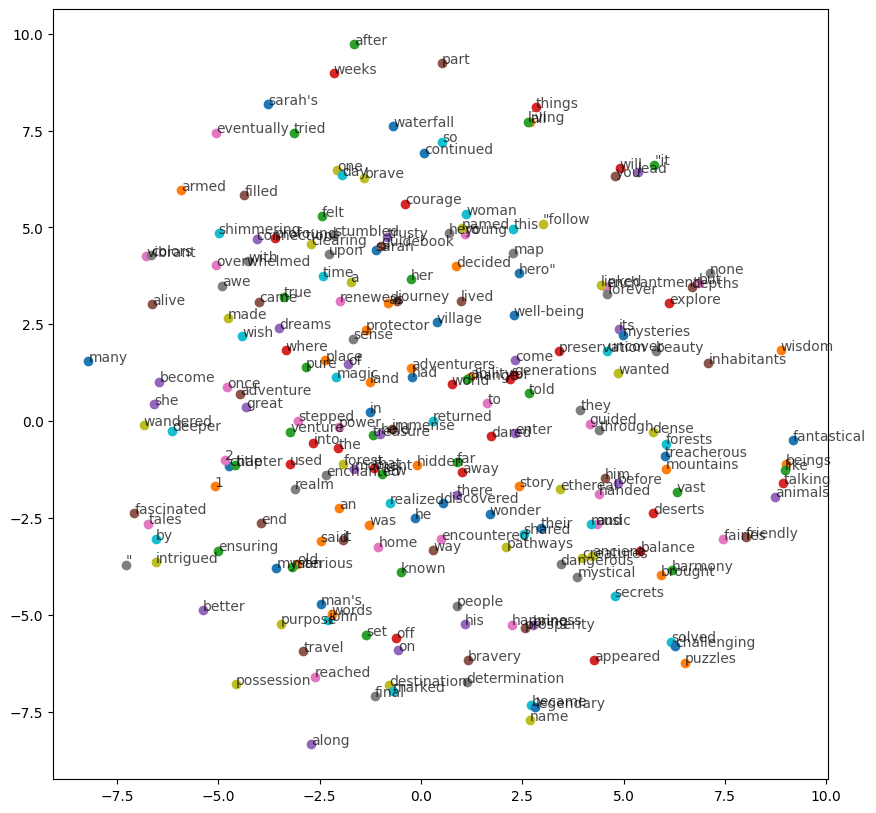

In [7]:
model.visualize_embeddings_tsne()